In [3]:
import cv2
import os
import random
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

In [7]:
DATASET_PATH = r'./images/'
TARGET_WIDTH = 320
TARGET_HEIGHT = 80
PADDING = 5

PYTESSERACT_CONFIG = '--psm 10 -c tessedit_char_whitelist=0123456789'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [13]:
def preprocess_image(image):
    original_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    _, th3 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    image = cv2.bitwise_not(th3)

    
    image = cv2.dilate(image, np.ones((1, 1), np.uint8), iterations=1)
    
    return image, original_image

In [14]:
def validate_character(character):
    character = character.strip()
    return character == '' or character == ' ' or character == None or len(character) > 1

In [27]:
def show_images(image_data):
    num_images = len(image_data)
    num_cols = 3 
    num_rows = int(np.ceil(num_images / num_cols)) * 2

    plt.figure(figsize=(15, 5 * (num_rows // 2))) 

    for i, (image, result_image) in enumerate(image_data):
        row_position = i // num_cols  
        col_position = i % num_cols 

        plt.subplot(num_rows, num_cols, row_position * num_cols * 2 + col_position + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # Hide the axes

        plt.subplot(num_rows, num_cols, (row_position * num_cols * 2 + col_position + 1) + num_cols)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off') 

    plt.tight_layout() 
    plt.show()

In [23]:
def segment_image(image, original_image=None, image_name='', type='write'):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)

        if hierarchy[0][idx][3] != None:
            
            if w < 10 and h < 10:
                continue
            
            start_x = np.max([0, x - PADDING])
            start_y = np.max([0, y - PADDING])
            
            end_x = np.min([TARGET_WIDTH, x + w + PADDING])
            end_y = np.min([TARGET_HEIGHT, y + h + PADDING])
            
            if type == 'write':
                character = pytesseract.image_to_string(
                    image[start_y:end_y, start_x:end_x], 
                    config=PYTESSERACT_CONFIG
                ).strip()
                
                if validate_character(character):
                    continue
                
                name = f'{character.strip()}-{image_name.split(".")[0]}-{idx}.png'
                
                cv2.imwrite(f'./characters/{name}', original_image[start_y:end_y, start_x:end_x])
            elif type == 'label':
                cv2.rectangle(original_image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    return original_image

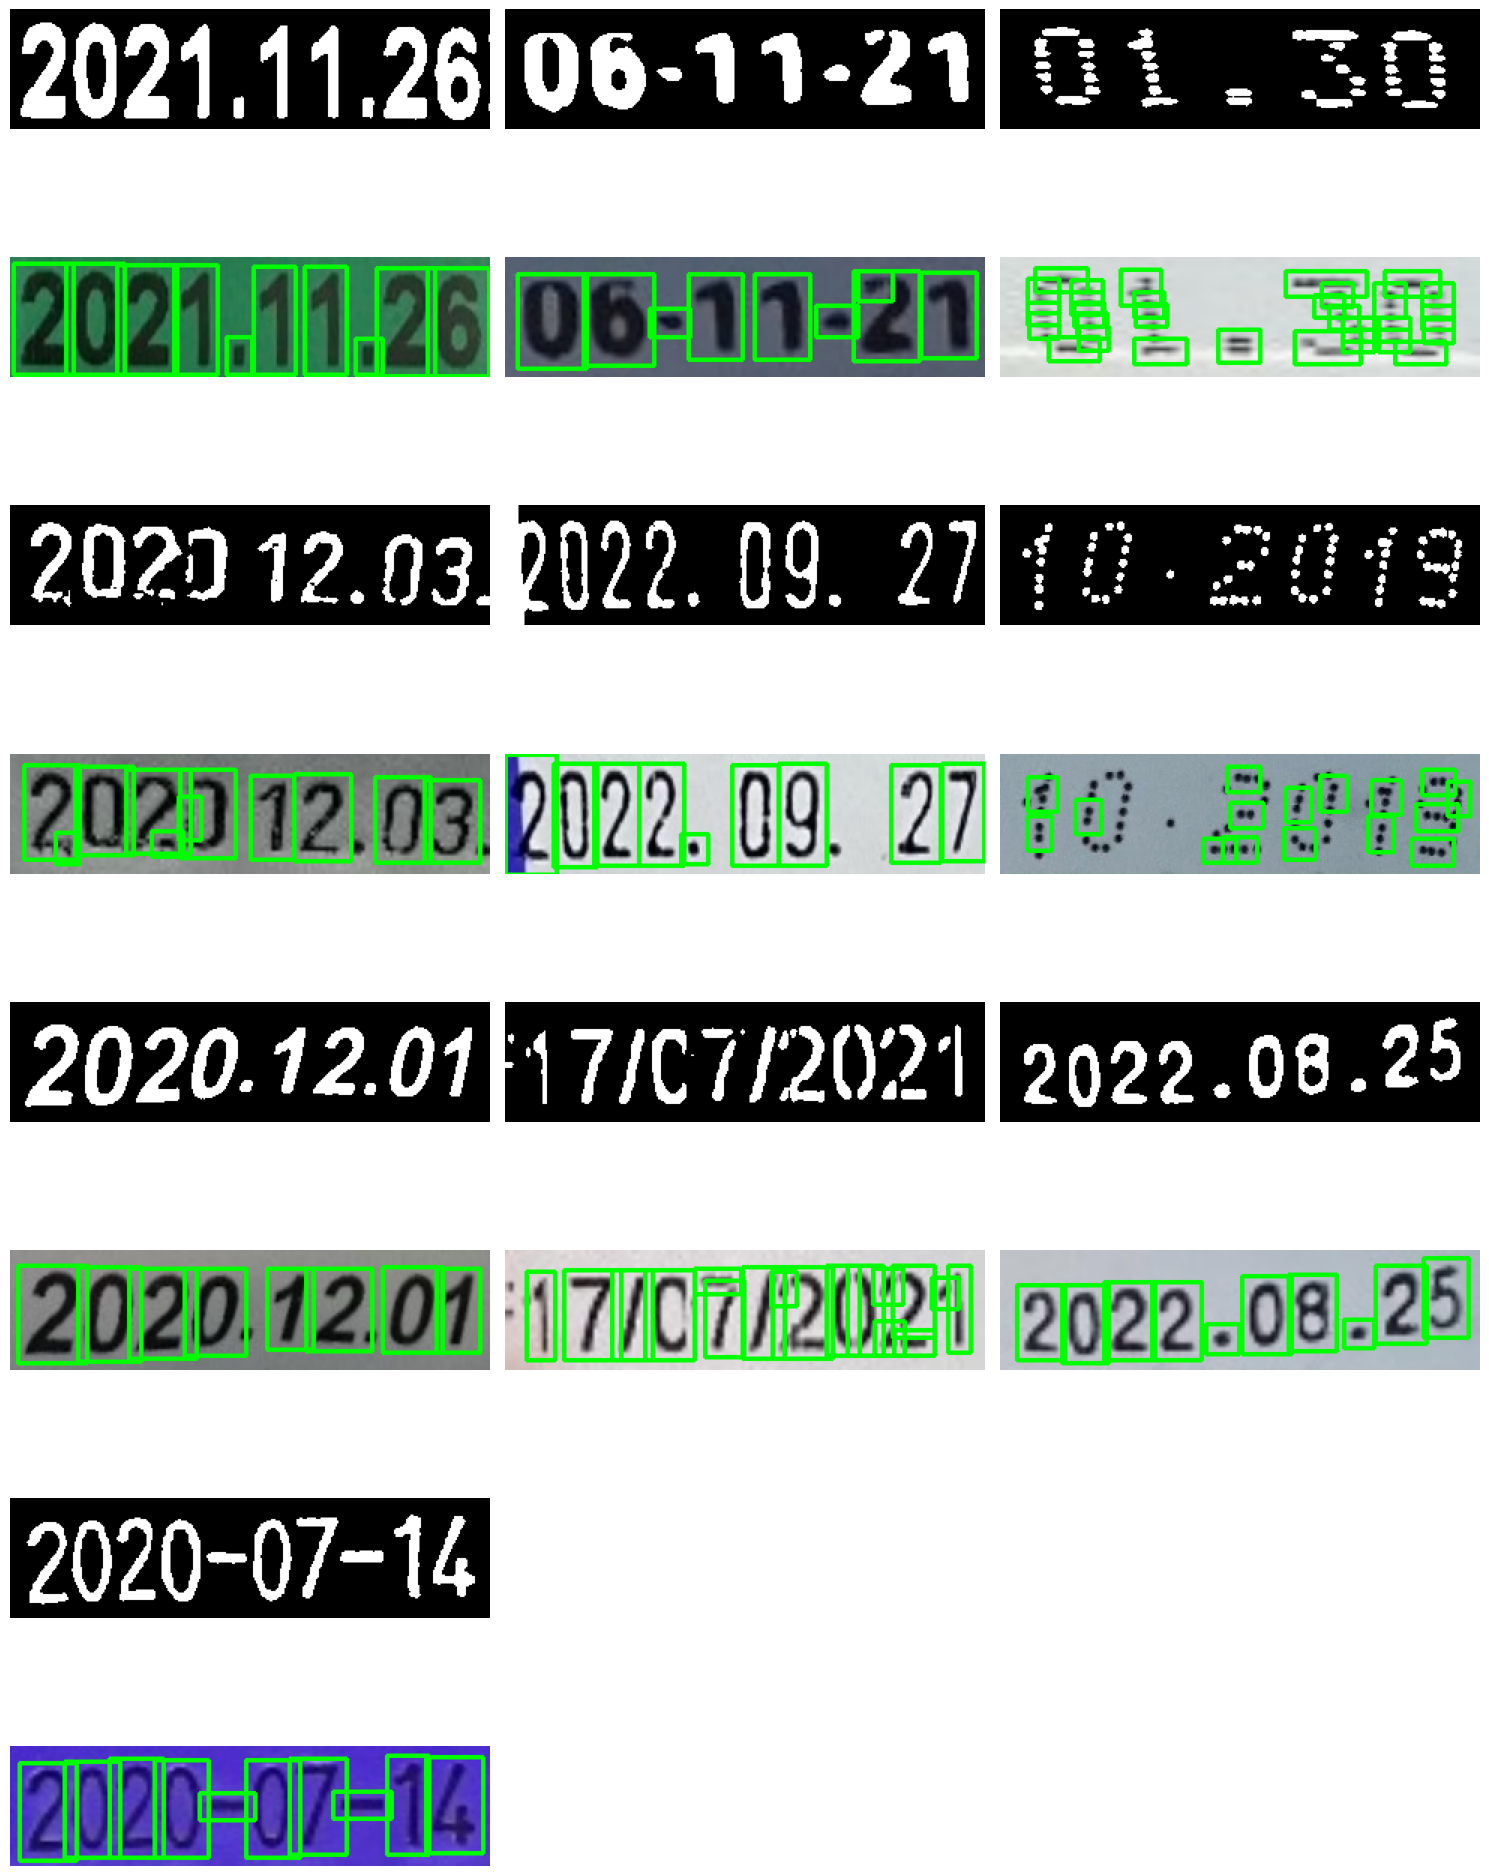

In [29]:

images = os.listdir(DATASET_PATH)

random.shuffle(images)

image_data = []
for image_name in images[:10]:
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)
    
    image, original_image = preprocess_image(original_image)
    
    labeled_image = segment_image(image, original_image, image_name, type='label')
    
    image_data.append((image, labeled_image))

show_images(image_data)

In [18]:
images = os.listdir(DATASET_PATH)

image_count = len(images)


for data_count, image_name in enumerate(images):
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)
    
    image, original_image = preprocess_image(original_image)
    
    segment_image(image, original_image, image_name, type='write')
            
    print(f'{data_count}/{image_count}')

0/510
1/510
2/510


KeyboardInterrupt: 